In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from pathlib import Path
import shutil
import itertools
import random
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
os.chdir('C:/Users/Nkosana/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'), 300):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 300):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 75):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 75):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 25):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 25):
        shutil.move(c, 'test/dog')

In [2]:

train_dir = 'C:/Users/Nkosana/dogs-vs-cats/train'
valid_dir = 'C:/Users/Nkosana/dogs-vs-cats/valid'

# Directory with our training cat pictures
train_cats_dir = 'C:/Users/Nkosana/dogs-vs-cats/train/cat'

# Directory with our training dog pictures
train_dogs_dir = 'C:/Users/Nkosana/dogs-vs-cats/train/dog'

# Directory with our validation cat pictures
validation_cats_dir = 'C:/Users/Nkosana/dogs-vs-cats/valid/cat'

# Directory with our validation dog pictures
validation_dogs_dir = 'C:/Users/Nkosana/dogs-vs-cats/valid/dog'

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 600 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [3]:
imgs, labels = next(train_generator)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes=axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

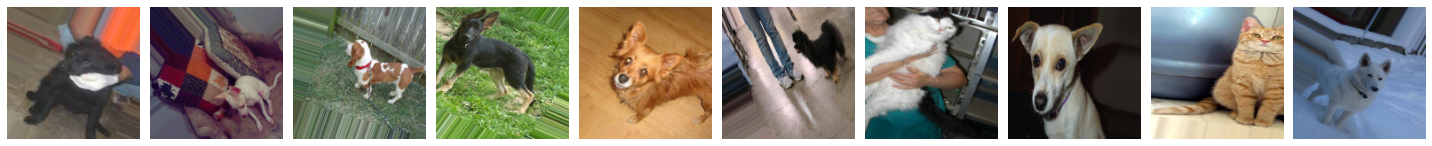

[1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.]


In [5]:
plotImages(imgs)
print(labels)

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 1223s 14us/step


In [7]:
# freazing the weights of the model
for layer in pre_trained_model.layers:
    layer.trainable = False


In [8]:
# last layerr for feature extraction
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [11]:
# stick fully connected classifier on top of last_output
from tensorflow.keras import Model
from tensorflow.keras import layers

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

C:\Users\Nkosana\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
model_history = model.fit(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/5
30/30 - 36s - loss: 0.2990 - acc: 0.8883 - val_loss: 0.1806 - val_acc: 0.9333 - 36s/epoch - 1s/step
Epoch 2/5
30/30 - 30s - loss: 0.2035 - acc: 0.9267 - 30s/epoch - 998ms/step
Epoch 3/5
30/30 - 30s - loss: 0.1854 - acc: 0.9250 - 30s/epoch - 1000ms/step
Epoch 4/5
30/30 - 30s - loss: 0.1280 - acc: 0.9450 - 30s/epoch - 1s/step
Epoch 5/5
30/30 - 30s - loss: 0.1464 - acc: 0.9483 - 30s/epoch - 1s/step


In [14]:
test_dir = 'C:/Users/Nkosana/dogs-vs-cats/test'

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary',
        shuffle=False)

Found 50 images belonging to 2 classes.


In [15]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

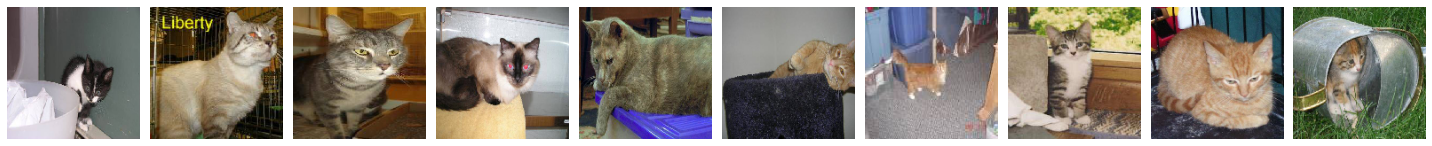

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
imgs, labels = next(test_generator)
plotImages(imgs)
print(labels)

In [17]:
prediction = model.predict(x=test_generator, verbose=0)

In [18]:
np.round(prediction)

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [19]:
# saving the model
model.save('models/dog_vs_cat.h5')

In [21]:
# loading the model
from tensorflow.keras.models import load_model
new_model = load_model('models/dog_vs_cat.h5')

In [22]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio